<a href="https://colab.research.google.com/github/Hoojon/Hoojon/blob/main/Satellite_segmentation_Prediction-GradioUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install -U segmentation-models

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!pip install gradio

In [36]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [37]:
import os
import cv2
from PIL import Image
import numpy as np
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

In [38]:
from keras import backend as K
from keras.models import load_model

In [39]:
import gradio as gr

In [40]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [41]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [42]:
satellite_model = load_model('/content/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [43]:
#satellite_model.get_config()

In [44]:
image = Image.open('/content/fc-img1.jpg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [45]:
prediction = satellite_model.predict(image)

1/1 [==============================] - 1s 629ms/step


In [46]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [47]:
type(predicted_image)

numpy.ndarray

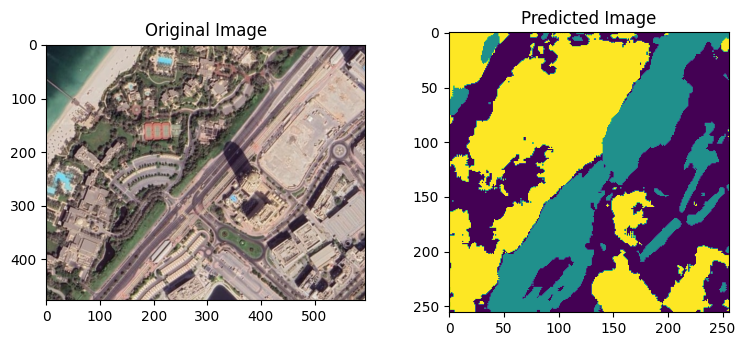

In [48]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/fc-img1.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [61]:
def process_input_image(image_sourcee):
  image_source = cv2.resize(image_sourcee, (256, 256))
  image = np.expand_dims(image_source, 0)

  prediction = satellite_model.predict(image)
  predicted_image = np.argmax(prediction, axis=3)

  predicted_image = predicted_image[0,:,:]
  predicted_image = predicted_image * 50
  return 'Predicted Masked Image', predicted_image

In [62]:
my_app = gr.Blocks()

In [63]:
with my_app:
  gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image")
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

In [64]:
my_app.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://6ff96448dd6abe526a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 179ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6ff96448dd6abe526a.gradio.live


In [65]:
my_app.close()

Closing server running on port: 7860
